# **Run inference with paths**

Execution line   
`python train.py eval_only --config configs/KITTITrackletsCarsHard.json --eval_epoch 28`

In [1]:
# Necessary imports
import datetime
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#import matplotlib
#matplotlib.use('Agg')

import sys
import os

tp_path = os.path.join('/home/usuario/project/align3d', 'tp_utils')
sys.path.insert(0, tp_path)

import provider
import copy
import models.tp8 as MODEL_tp8
from config import load_config, configGlobal, save_config

from argparse import Namespace

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Load config and model


In [3]:
FLAGS = Namespace(config='configs/KITTITrackletsCarsHard.json', 
                  eval_epoch='28', 
                  its=30, 
                  operation='eval_only', 
                  refineICP=False, 
                  refineICPmethod='p2p', 
                  use_old_results=False)
load_config(FLAGS.config)

# temp fix
TRAIN_INDICES = provider.getDataFiles(f'{configGlobal.data.basepath}/split/train.txt')
VAL_INDICES = provider.getDataFiles(f'{configGlobal.data.basepath}/split/val.txt')[:200]
configGlobal.data.__dict__["ntrain"] = len(TRAIN_INDICES)
configGlobal.data.__dict__["nval"] = len(VAL_INDICES)

cfg = configGlobal

MODEL = MODEL_tp8

In [4]:
import time

In [5]:
eval_only_model_to_load=None
eval_only=True
eval_epoch=FLAGS.eval_epoch
do_timings=False
override_batch_size=None

In [6]:
with tf.Graph().as_default():
    
    # Define model on the device
    with tf.device('/gpu:' + str(cfg.gpu_index)):
        pcs1, pcs2, translations, rel_angles, pc1centers, pc2centers, pc1angles, pc2angles = MODEL.placeholder_inputs(cfg.training.batch_size, cfg.model.num_points)
        is_training_pl = tf.placeholder(tf.bool, shape=())

        # Note the global_step=batch parameter to minimize.
        # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
        batch = tf.Variable(0)
        #bn_decay = get_bn_decay(batch)
        
        # Get model and loss
        end_points = MODEL.get_model(pcs1, pcs2, is_training_pl)
        loss = MODEL.get_loss(pcs1, pcs2, translations, rel_angles, pc1centers, pc2centers, pc1angles, pc2angles, end_points)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver(max_to_keep=1000)
        
    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    
    sess = tf.Session(config=config)
    
    merged = tf.summary.merge_all() # Necessary to run


    # Init variables
    init = tf.global_variables_initializer()
    
    # To fix the bug introduced in TF 0.12.1 as in
    # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
    # sess.run(init)
    sess.run(init, {is_training_pl: True})
    
    ops = {'pcs1': pcs1, # INPUT
           'pcs2': pcs2, # INPUT
           'translations': translations, # GT 
           'rel_angles': rel_angles,     # gt
           'is_training_pl': is_training_pl, # What is it for?
           'pred_translations': end_points['pred_translations'], 
           'pred_remaining_angle_logits': end_points['pred_remaining_angle_logits'], 
           'pc1centers': pc1centers,     # GT
           'pc2centers': pc2centers,     # GT
           'pc1angles': pc1angles,       # GT
           'pc2angles': pc2angles,       # GT
           'pred_s1_pc1centers': end_points['pred_s1_pc1centers'], 
           'pred_s1_pc2centers': end_points['pred_s1_pc2centers'], 
           'pred_s2_pc1centers': end_points['pred_s2_pc1centers'], 
           'pred_s2_pc2centers': end_points['pred_s2_pc2centers'], 
           'pred_pc1angle_logits': end_points['pred_pc1angle_logits'], 
           'pred_pc2angle_logits': end_points['pred_pc2angle_logits'], 
           'loss': loss,                 # COMPUTED
           'merged': merged}             # WHAT IS THIS??
           #'train_op': train_op, 
           #'step': batch}                # INFO

    
    # Load existing model!!!!!!!!!!!!!!!!!!!!!
    model_to_load = cfg.logging.logdir
    assert os.path.isfile(f'{model_to_load}/model-{eval_epoch}.index'), f'{model_to_load}/model-{eval_epoch}.index'
    saver.restore(sess, f'{model_to_load}/model-{eval_epoch}')
    
    start_epoch = int(eval_epoch)
    epoch = start_epoch
    
    num_batches_per_epoch = len(TRAIN_INDICES) // cfg.training.batch_size
    
    is_training = False
    batch_size = cfg.training.batch_size

    val_idxs = VAL_INDICES
    num_batches = int(np.ceil(len(val_idxs) / batch_size))
    num_full_batches = int(np.floor(len(val_idxs) / batch_size))

    loss_sum = 0
    #global_step = sess.run([ops['step']])[0]
    
    #  step_in_epochs = epoch + 1
    eval_dir = f'{cfg.logging.logdir}/val/eval{str(epoch).zfill(6)}'
    base_eval_dir = eval_dir
    if FLAGS.refineICP:
        eval_dir = f'{eval_dir}/refined_{FLAGS.refineICPmethod}{"_"+FLAGS.its if FLAGS.its != 30 else ""}'

    if os.path.isdir(eval_dir):
        os.rename(eval_dir, f'{eval_dir}_backup_{int(time.time())}')

    os.makedirs(eval_dir, exist_ok=True)

    # Prediction containers
    all_pred_translations = np.empty((len(val_idxs), 3), dtype=np.float32)
    all_pred_angles = np.empty((len(val_idxs), 1), dtype=np.float32)
    
    # The conversion from logits to is done outside the model
    # Pass this to the model!
    all_pred_s2_pc1angles = np.empty((len(val_idxs), 1), dtype=np.float32)
    all_pred_s2_pc2angles = np.empty((len(val_idxs), 1), dtype=np.float32)
    
    # Ground truth contina
    all_gt_translations = np.empty((len(val_idxs), 3), dtype=np.float32)
    all_gt_angles = np.empty((len(val_idxs), 1), dtype=np.float32)
    all_gt_pc1centers = np.empty((len(val_idxs), 3), dtype=np.float32)
    
    cumulated_times = 0.
    for batch_idx in range(num_batches):
        
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(val_idxs))
        
        print(f'----- Samples {start_idx}/{len(VAL_INDICES)} -----')
        
        # TODO: Create a class to solve this shit
        pcs1, pcs2, translations, rel_angles, pc1centers, pc2centers, pc1angles, pc2angles = provider.load_batch(val_idxs[start_idx:end_idx])

        # TODO: Investigate a better way to do this feed_dict
        feed_dict = {
            ops['pcs1']: pcs1,
            ops['pcs2']: pcs2,
            ops['translations']: translations,
            ops['rel_angles']: rel_angles,
            ops['is_training_pl']: is_training,
            ops['pc1centers']: pc1centers,
            ops['pc2centers']: pc2centers,
            ops['pc1angles']: pc1angles,
            ops['pc2angles']: pc2angles,
        }
        start = time.time()
        
        # TODO: IDEM Create class to solve this mess
        summary, loss_val, pred_translations,pred_pc1angle_logits, pred_pc2angle_logits, pred_remaining_angle_logits, _, _, _, _ = sess.run([ops['merged'], ops['loss'], ops['pred_translations'], ops['pred_pc1angle_logits'], ops['pred_pc2angle_logits'], ops['pred_remaining_angle_logits'], ops['pred_s1_pc1centers'], ops['pred_s1_pc2centers'], ops['pred_s2_pc1centers'], ops['pred_s2_pc2centers']], feed_dict=feed_dict)
        
        # Why do we need time?
        cumulated_times += time.time() - start
        # ?
        actual_batch_size = end_idx - start_idx
        
        # How can this be longer? Maybe when not full batch
        pred_translations = pred_translations[:actual_batch_size]
        # Correct from logits to angle
        pred_angles_pc1 = MODEL.classLogits2angle(pred_pc1angle_logits[:actual_batch_size])
        pred_angles_pc2 = MODEL.classLogits2angle(pred_pc2angle_logits[:actual_batch_size])
        pred_angles_remaining = MODEL.classLogits2angle(pred_remaining_angle_logits[:actual_batch_size])
        # Final angle computation
        pred_angles = pred_angles_pc2 - pred_angles_pc1 + pred_angles_remaining
        
        # Why this?
        if actual_batch_size == batch_size:  # last batch is not counted
            loss_sum += loss_val
        
        # Some parameters (ARE THEY NEEDED?)
        mean_per_transform_loss = loss_sum / num_full_batches if num_full_batches > 0 else 0.
        mean_execution_time = cumulated_times / float(len(val_idxs))
        
        print(f"{loss_val}")
        
        # Store result to big array TODO: CONVERT TO SINGLE LINE OP
        for idx in range(actual_batch_size):
            global_idx = start_idx + idx

            all_pred_translations[global_idx] = pred_translations[idx]
            all_pred_angles[global_idx] = pred_angles[idx]

            all_gt_translations[global_idx] = translations[idx]
            all_gt_angles[global_idx] = rel_angles[idx]
            all_gt_pc1centers[global_idx] = pc1centers[idx]
        
        print("Results stored")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Restoring parameters from /home/usuario/project_data/trained/KITTITrackletsCarsHard/model-28
----- Samples 0/200 -----
0.06758423149585724
Results stored
----- Samples 128/200 -----
nan
Results stored


In [11]:
info

[array([[ 1.94407578e+01, -2.31924782e+01,  3.15420359e-01],
        [-3.89489670e+01,  2.46781425e+01, -4.97459173e-02],
        [-1.70562515e+01,  3.75968170e+01, -1.64849937e-01],
        [-6.61296320e+00,  2.12124348e+01,  1.30958974e-01],
        [ 3.34415197e+00, -1.97183967e+00, -1.88874707e-01],
        [-6.94978619e+00,  2.57925758e+01,  4.73267257e-01],
        [-9.80705166e+00,  2.31590538e+01,  4.19113994e-01],
        [-4.38593979e+01,  4.71579514e+01, -4.15005028e-01],
        [-2.16634083e+01,  7.52007008e+00, -1.71391547e-01],
        [-2.11788616e+01,  2.20654678e+01, -1.45735383e-01],
        [-3.46175728e+01,  2.72780266e+01, -2.05025852e-01],
        [-1.90861320e+01,  1.42782822e+01, -9.30262804e-02],
        [-3.45465012e+01,  3.45031052e+01, -6.69012070e-02],
        [-4.70238228e+01,  4.75937958e+01, -3.25573713e-01],
        [-4.24558029e+01,  4.48664131e+01, -4.23216581e-01],
        [-3.20246239e+01,  4.02558365e+01, -4.20309156e-01],
        [-1.78617716e+00

In [22]:
info = np.hstack((all_pred_translations[:,:-1], all_pred_angles, all_gt_translations[:,:-1], all_gt_angles, all_gt_pc1centers[:,:-1]))
names = ['pred_trans_x', 'pred_trans_y', 'pred_angles', 'gt_trans_x', 'gt_trans_y', 'gt_angles', 'gt_pc1centers_x', 'gt_pc1centers_y']

In [21]:
len(names)

7

In [20]:
info

array([[ 19.440758 , -23.192478 ,   7.1925607, ...,  -1.7448511,
         45.98802  ,  13.604723 ],
       [-38.948967 ,  24.678143 ,  -1.1224004, ...,   4.827299 ,
         61.38027  , -16.407194 ],
       [-17.056252 ,  37.596817 ,  -1.1790311, ...,   5.0773373,
         38.57874  , -32.08969  ],
       ...,
       [-27.375225 ,  32.132206 ,   1.793374 , ...,   4.931479 ,
         44.858162 , -25.220554 ],
       [-26.671196 ,  42.880123 ,   1.7394004, ...,   4.951042 ,
         45.49268  , -36.725845 ],
       [-16.097563 ,  29.014782 ,  -3.3471322, ...,  -0.8824531,
         35.342663 , -26.696596 ]], dtype=float32)

In [7]:
import pandas as pd

In [23]:
pd.DataFrame(info, columns=names)

,pred_trans_x,pred_trans_y,pred_angles,gt_trans_x,pred_trans_y,gt_angles,gt_pc1centers_x,gt_pc1centers_y
0,19.440758,-23.192478,7.192561,19.882133,-24.059345,-1.744851,45.988022,13.604723
1,-38.948967,24.678143,-1.122400,-38.724640,24.064154,4.827299,61.380268,-16.407194
2,-17.056252,37.596817,-1.179031,-17.169388,37.013393,5.077337,38.578739,-32.089691
3,-6.612963,21.212435,-3.660400,-6.562392,21.292234,-1.031201,20.688881,-13.932587
4,3.344152,-1.971840,5.215176,3.234634,-2.046608,-0.951331,32.198730,10.548253
...,...,...,...,...,...,...,...,...
195,-25.298983,23.900253,8.531916,-25.443947,23.756832,5.464684,59.313564,-24.992565
196,-22.082436,47.904739,3.306987,-20.937563,47.687691,-0.837914,48.574284,-36.383560
197,-27.375225,32.132206,1.793374,-26.886805,32.291672,4.931479,44.858162,-25.220554
198,-26.671196,42.880123,1.739400,-26.612957,43.021095,4.951042,45.492680,-36.725845


In [ ]:
    import pandas as import pd

In [17]:
all_pred_angles.shape

(200, 1)

In [24]:
info = np.hstack((all_pred_translations[:,:-1], all_pred_angles, all_gt_translations[:,:-1], all_gt_angles, all_gt_pc1centers[:,:-1]))
names = ['pred_trans_x', 'pred_trans_y', 'pred_angles', 'gt_trans_x', 'gt_trans_y', 'gt_angles', 'gt_pc1centers_x', 'gt_pc1centers_y']

df = pd.DataFrame(info, columns=names)
df.to_csv('output.csv')    

## Provider analysis

In [7]:
import os, sys
tp_path = os.path.join('/home/usuario/project/align3d', 'tp_utils')
sys.path.insert(0, tp_path)
import provider
import numpy as np
%autoreload 2



UsageError: Line magic function `%autoreload` not found.


In [3]:
batch_size = 128

In [4]:
num_batches = int(np.ceil(len(val_idxs) / batch_size))
num_full_batches = int(np.floor(len(val_idxs) / batch_size))

In [5]:
dataset_path = '/home/usuario/project_data/datasets/KITTITrackletsCarsPersons'


In [17]:
len(val_idxs)

210

In [21]:
dataset_path

'/home/usuario/project_data/datasets/KITTITrackletsCarsPersons'

----- Samples 0/210 -----


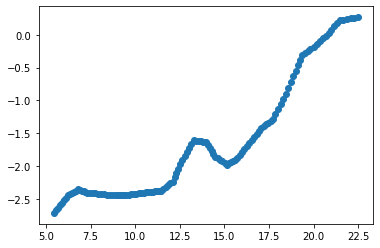

----- Samples 128/210 -----


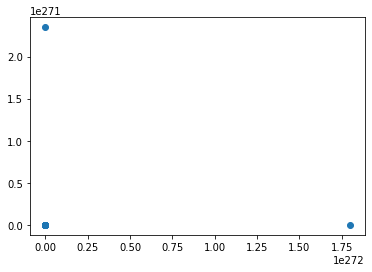

In [23]:

for batch_idx in range(2):           
    # AQUI ERROR!
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(val_idxs))

    print(f'----- Samples {start_idx}/{len(val_idxs)} -----')

    # TODO: Create a class to solve this mess
    pcs1, pcs2, translations, rel_angles, pc1centers, pc2centers, pc1angles, pc2angles = provider.load_batch(val_idxs[start_idx:end_idx], override_batch_size=128,path=dataset_path)
    #print(pc1centers)
    import matplotlib.pyplot as plt
    plt.scatter(pc1centers[:,0], pc1centers[:,1])
    plt.show()

In [33]:
batch_size = 128

In [41]:
import pandas as pd

In [42]:
dataset_name = 'KITTITrackletsCarsPersons'
df = pd.read_csv(f'/home/usuario/project_data/new_datasets/{dataset_name}/{dataset_name}_eval_info.csv')
df_cumsum = df['cumsum_n_points']

In [44]:
df

,name,type,n_points,cumsum_n_points,cumsum_n_points_fromzero
0,19_24,E,210,28488,0
1,19_25,E,59,28698,210
2,19_26,E,56,28757,269
3,19_27,E,40,28813,325
4,19_29,E,155,28853,365
...,...,...,...,...,...
172,20_129,E,18,40473,11985
173,20_130,E,3,40491,12003
174,20_131,E,3,40494,12006
175,20_132,E,12,40497,12009


In [43]:
df_cumsum

0      28488
1      28698
2      28757
3      28813
4      28853
       ...  
172    40473
173    40491
174    40494
175    40497
176    40509
Name: cumsum_n_points, Length: 177, dtype: int64

In [39]:
val_idxs

['00016416',
 '00016417',
 '00016418',
 '00016419',
 '00016420',
 '00016421',
 '00016422',
 '00016423',
 '00016424',
 '00016425',
 '00016426',
 '00016427',
 '00016428',
 '00016429',
 '00016430',
 '00016431',
 '00016432',
 '00016433',
 '00016434',
 '00016435',
 '00016436',
 '00016437',
 '00016438',
 '00016439',
 '00016440',
 '00016441',
 '00016442',
 '00016443',
 '00016444',
 '00016445',
 '00016446',
 '00016447',
 '00016448',
 '00016449',
 '00016450',
 '00016451',
 '00016452',
 '00016453',
 '00016454',
 '00016455',
 '00016456',
 '00016457',
 '00016458',
 '00016459',
 '00016460',
 '00016461',
 '00016462',
 '00016463',
 '00016464',
 '00016465',
 '00016466',
 '00016467',
 '00016468',
 '00016469',
 '00016470',
 '00016471',
 '00016472',
 '00016473',
 '00016474',
 '00016475',
 '00016476',
 '00016477',
 '00016478',
 '00016479',
 '00016480',
 '00016481',
 '00016482',
 '00016483',
 '00016484',
 '00016485',
 '00016486',
 '00016487',
 '00016488',
 '00016489',
 '00016490',
 '00016491',
 '00016492',

----- Samples 0/210 -----
----- Samples 128/210 -----


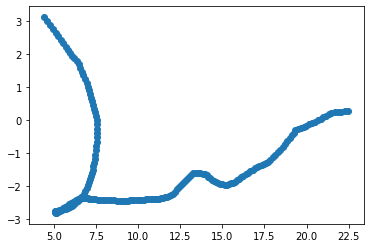

In [38]:
# Prediction containers
all_pred_translations = np.empty((len(val_idxs), 3), dtype=np.float32)
all_pred_angles = np.empty((len(val_idxs), 1), dtype=np.float32)

# The conversion from logits to is done outside the model
# Pass this to the model!
all_pred_s2_pc1angles = np.empty((len(val_idxs), 1), dtype=np.float32)
all_pred_s2_pc2angles = np.empty((len(val_idxs), 1), dtype=np.float32)

# Ground truth contina
all_gt_translations = np.empty((len(val_idxs), 3), dtype=np.float32)
all_gt_angles = np.empty((len(val_idxs), 1), dtype=np.float32)
all_gt_pc1centers = np.empty((len(val_idxs), 3), dtype=np.float32)

cumulated_times = 0.
for batch_idx in range(2):

    # AQUI ERROR!
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(val_idxs))

    print(f'----- Samples {start_idx}/{len(val_idxs)} -----')

    # TODO: Create a class to solve this mess
    pcs1, pcs2, translations, rel_angles, pc1centers, pc2centers, pc1angles, pc2angles = provider.load_batch(val_idxs[start_idx:end_idx],override_batch_size=128 , path=dataset_path)
    

    actual_batch_size = end_idx - start_idx


    # Store result to big array TODO: CONVERT TO SINGLE LINE OP
    for idx in range(actual_batch_size):
        global_idx = start_idx + idx
        all_gt_pc1centers[global_idx] = pc1centers[idx]

import matplotlib.pyplot as plt
plt.scatter(all_gt_pc1centers[:,0], all_gt_pc1centers[:,1])
plt.show()

In [12]:
pc1centers[:,:]

array([[ 2.24814243e+01,  2.67892003e-01, -4.19815004e-01],
       [ 2.22771454e+01,  2.58727014e-01, -3.87060940e-01],
       [ 2.20728722e+01,  2.49543995e-01, -3.56047928e-01],
       [ 2.18688736e+01,  2.39355996e-01, -4.17865932e-01],
       [ 2.16646023e+01,  2.30161995e-01, -3.87878001e-01],
       [ 2.14605942e+01,  2.20014006e-01, -4.46008980e-01],
       [ 2.13036156e+01,  1.72826007e-01, -4.79616940e-01],
       [ 2.11466351e+01,  1.25636995e-01, -5.13225019e-01],
       [ 2.09896564e+01,  7.84479976e-02, -5.46832979e-01],
       [ 2.08326759e+01,  3.12599987e-02, -5.80439985e-01],
       [ 2.06756973e+01, -1.59290005e-02, -6.14047945e-01],
       [ 2.05041237e+01, -5.61259985e-02, -5.40551960e-01],
       [ 2.03327904e+01, -9.72059965e-02, -5.48678935e-01],
       [ 2.01614590e+01, -1.38289005e-01, -5.57056963e-01],
       [ 1.99901752e+01, -1.79543003e-01, -5.81299007e-01],
       [ 1.98187180e+01, -2.20170006e-01, -5.47517002e-01],
       [ 1.96580467e+01, -2.50952005e-01